In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import scipy.stats as stats

from parameters import *

import save_n_load as sl
import clustering as cl
import hit_stat as hs
import aux

In [2]:
X_COORDS, Y_COORDS, Z_COORDS = laura_load_coordinate_arrays() if GEOMETRY_VERSION == "v4" else v5_load_coordinate_arrays(detector=DETECTOR)

print(len(X_COORDS[X_COORDS < 0]))

112


## Load SN events

In [3]:
detector = "VD"

if detector == "VD":
    sn_data_dir = EVENT_DATA_DIR
    sim_mode = "xe"
elif detector == "HD":
    sn_data_dir = ""
    sim_mode = "aronly"

sn_total_hits, sn_hit_list_per_event, sn_info_per_event, _ = sl.load_all_sn_events_chunky(limit=100, event_num=1000, detector=detector, sn_data_dir=sn_data_dir,
                                                                                          sim_mode=sim_mode)

print(len(sn_hit_list_per_event), len(sn_info_per_event))

90000 90000


## Load the BG

In [4]:
detector = "VD"
X_COORDS, Y_COORDS, Z_COORDS = laura_load_coordinate_arrays() if GEOMETRY_VERSION == "v4" else v5_load_coordinate_arrays(detector=detector)
bg_limit = 10

if detector == "VD":
    bg_types = [
        "Ar39GenInLAr", "Kr85GenInLAr", "Ar42GenInLAr","K42From42ArGenInLAr",
        "Rn222ChainRn222GenInLAr",
        "Rn222ChainPo218GenInLAr",
        "Rn222ChainPb214GenInLAr",
        "Rn222ChainBi214GenInLAr",
        "Rn222ChainPb210GenInLAr",
        "Rn220ChainPb212GenInLAr",
        "K40GenInCathode",
        "U238ChainGenInCathode",
        "Th232ChainGenInCathode",
        "K40GenInAnode",
        "U238ChainGenInAnode",
        "Th232ChainGenInAnode",
        "Rn222ChainGenInPDS",
        "K42From42ArGenInUpperMesh1x8x14",
        "Rn222ChainFromPo218GenInUpperMesh1x8x14",
        "Rn222ChainFromPb214GenInUpperMesh1x8x14",
        "Rn222ChainFromBi214GenInUpperMesh1x8x14",
        "Rn222ChainFromPb210GenInUpperMesh1x8x14",
        "Rn222ChainFromBi210GenInUpperMesh1x8x14",
        "Rn220ChainFromPb212GenInUpperMesh1x8x14",
        "CavernwallGammasAtLAr1x8x14",
        "foamGammasAtLAr1x8x14",
        "CavernwallNeutronsAtLAr1x8x14",
        "CryostatNGammasAtLAr1x8x14",
        "CavernNGammasAtLAr1x8x14"
    ]
    bg_data_dir = BG_DATA_DIR
    sim_mode = "xe"

    bg_sample_length = 8.5 # ms
    num_channels = 184
    num_arapucas = 184
    size_arapucas = 60 * 60 # cm ^ 2

    # Total number of arapucas: 672, of which in cathode: 320 (double rate)
    # In v5 geometry: 184, 112 in cathode (double rate)
    wall_rate_mult = (672 - 320) / (184 - 112)
    cathode_rate_mult = 320 / 112
    cathode_num_channels = 112
    wall_num_channels = 72

elif detector == "HD":
    bg_types = [
        "Ar39GenInLAr", "Kr85GenInLAr", "Ar42GenInLAr", "K42From42ArGenInLAr",
        "Rn222ChainRn222GenInLAr", "Rn222ChainPo218GenInLAr", "Rn222ChainPb214GenInLAr",
        "Rn222ChainBi214GenInLAr", "Rn222ChainPb210GenInLAr", "Rn220ChainPb212GenInLAr",
        "K40GenInCPA", "U238ChainGenInCPA", "K42From42ArGenInCPA",
        "Rn222ChainPo218GenInCPA", "Rn222ChainPb214GenInCPA", "Rn222ChainBi214GenInCPA",
        "Rn222ChainPb210GenInCPA", "Rn222ChainFromBi210GenInCPA", "Rn220ChainFromPb212GenInCPA",
        "Co60GenInAPA", "U238ChainGenInAPA", "Th232ChainGenInAPA",
        "Rn222ChainGenInPDS", "CavernwallGammasAtLAr", "foamGammasAtLAr",
        "CavernwallNeutronsAtLAr", "CryostatNGammasAtLAr", "CavernNGammasAtLAr"
    ]

    bg_data_dir = "/Users/pbarham/OneDrive/workspace/cern/ruth/v3_hd_background/"
    sim_mode = "aronly"

    bg_sample_length = 4.492 # ms
    num_channels = 480
    num_arapucas = 480 // 4
    size_arapucas = 50 * 10 # cm ^ 2

    # 1000 arapucas on the cathode, with 4 channels each
    total_rate_mult = (500 * 4 + 1000/2 * 4) / num_channels


bg_total_hits, bg_hit_list_per_event, _, bg_total_hits_per_type, bg_hit_list_per_event_per_type =\
                                    sl.load_all_backgrounds_chunky_type_separated(limit=bg_limit, detector=detector, adc_mode="normal",
                                            sim_mode=sim_mode, offset=1, bg_types=bg_types, bg_data_dir=bg_data_dir);

### Define BG agrupations for same isotope types

In [5]:
Rn222ChainInLAr_group = ["Rn222ChainRn222GenInLAr",
        "Rn222ChainPo218GenInLAr",
        "Rn222ChainPb214GenInLAr",
        "Rn222ChainBi214GenInLAr",
        "Rn222ChainPb210GenInLAr",
        "Rn220ChainPb212GenInLAr"]
Rn222ChainInUpperMesh_group = ["Rn222ChainFromPo218GenInUpperMesh1x8x14",
        "Rn222ChainFromPb214GenInUpperMesh1x8x14",
        "Rn222ChainFromBi214GenInUpperMesh1x8x14",
        "Rn222ChainFromPb210GenInUpperMesh1x8x14",
        "Rn222ChainFromBi210GenInUpperMesh1x8x14",
        "Rn220ChainFromPb212GenInUpperMesh1x8x14"]
Gammas_group = ["CavernwallGammasAtLAr1x8x14", "foamGammasAtLAr1x8x14"]
Neutrons_group = ["CavernwallNeutronsAtLAr1x8x14", "CryostatNGammasAtLAr1x8x14", "CavernNGammasAtLAr1x8x14"]


grouped_bg_types = [
        "Rn222ChainInLAr",
        "Rn222ChainInUpperMesh",
        "Gammas",
        "Neutrons"]

bg_types_list_per_group = {"Rn222ChainInLAr": Rn222ChainInLAr_group,
                            "Rn222ChainInUpperMesh": Rn222ChainInUpperMesh_group,
                            "Gammas": Gammas_group,
                            "Neutrons": Neutrons_group}

ungrouped_bg_types = [
        "Ar39GenInLAr", "Kr85GenInLAr", "Ar42GenInLAr","K42From42ArGenInLAr",
        "Rn220ChainPb212GenInLAr",
        "K40GenInCathode",
        "U238ChainGenInCathode",
        "Th232ChainGenInCathode",
        "K40GenInAnode",
        "U238ChainGenInAnode",
        "Th232ChainGenInAnode",
        "Rn222ChainGenInPDS",
        "K42From42ArGenInUpperMesh1x8x14",
    ]

# Length of hit list for "Rn222ChainRn222GenInLAr"
# TODO: make bg_hit_list_per_event_per_type a dictionary
rnlar_len = len(bg_hit_list_per_event_per_type[4])
rnpds_len = len(bg_hit_list_per_event_per_type[18])
gammas_len = len(bg_hit_list_per_event_per_type[-1])
neutrons_len = len(bg_hit_list_per_event_per_type[-4])

bg_hit_list_per_event_per_grouped_type = {"Rn222ChainInLAr": [[] for _ in range(rnlar_len)],
                                         "Rn222ChainInUpperMesh": [[] for _ in range(rnpds_len)],
                                         "Gammas": [[] for _ in range(gammas_len)],
                                         "Neutrons": [[] for _ in range(neutrons_len)]}

for grouped_type in grouped_bg_types:
    for i, bg_type in enumerate(bg_types_list_per_group[grouped_type]):
        print(i, bg_type)
        for j, type in enumerate(bg_types):
            if type == bg_type:
                for k, hit_list in enumerate(bg_hit_list_per_event_per_type[j]):
                    bg_hit_list_per_event_per_grouped_type[grouped_type][k].extend(hit_list)

0 Rn222ChainRn222GenInLAr
1 Rn222ChainPo218GenInLAr
2 Rn222ChainPb214GenInLAr
3 Rn222ChainBi214GenInLAr
4 Rn222ChainPb210GenInLAr
5 Rn220ChainPb212GenInLAr
0 Rn222ChainFromPo218GenInUpperMesh1x8x14
1 Rn222ChainFromPb214GenInUpperMesh1x8x14
2 Rn222ChainFromBi214GenInUpperMesh1x8x14
3 Rn222ChainFromPb210GenInUpperMesh1x8x14
4 Rn222ChainFromBi210GenInUpperMesh1x8x14
5 Rn220ChainFromPb212GenInUpperMesh1x8x14
0 CavernwallGammasAtLAr1x8x14
1 foamGammasAtLAr1x8x14
0 CavernwallNeutronsAtLAr1x8x14
1 CryostatNGammasAtLAr1x8x14
2 CavernNGammasAtLAr1x8x14


### Plot the frequency per Arapuca of each BG type

<IPython.core.display.Javascript object>


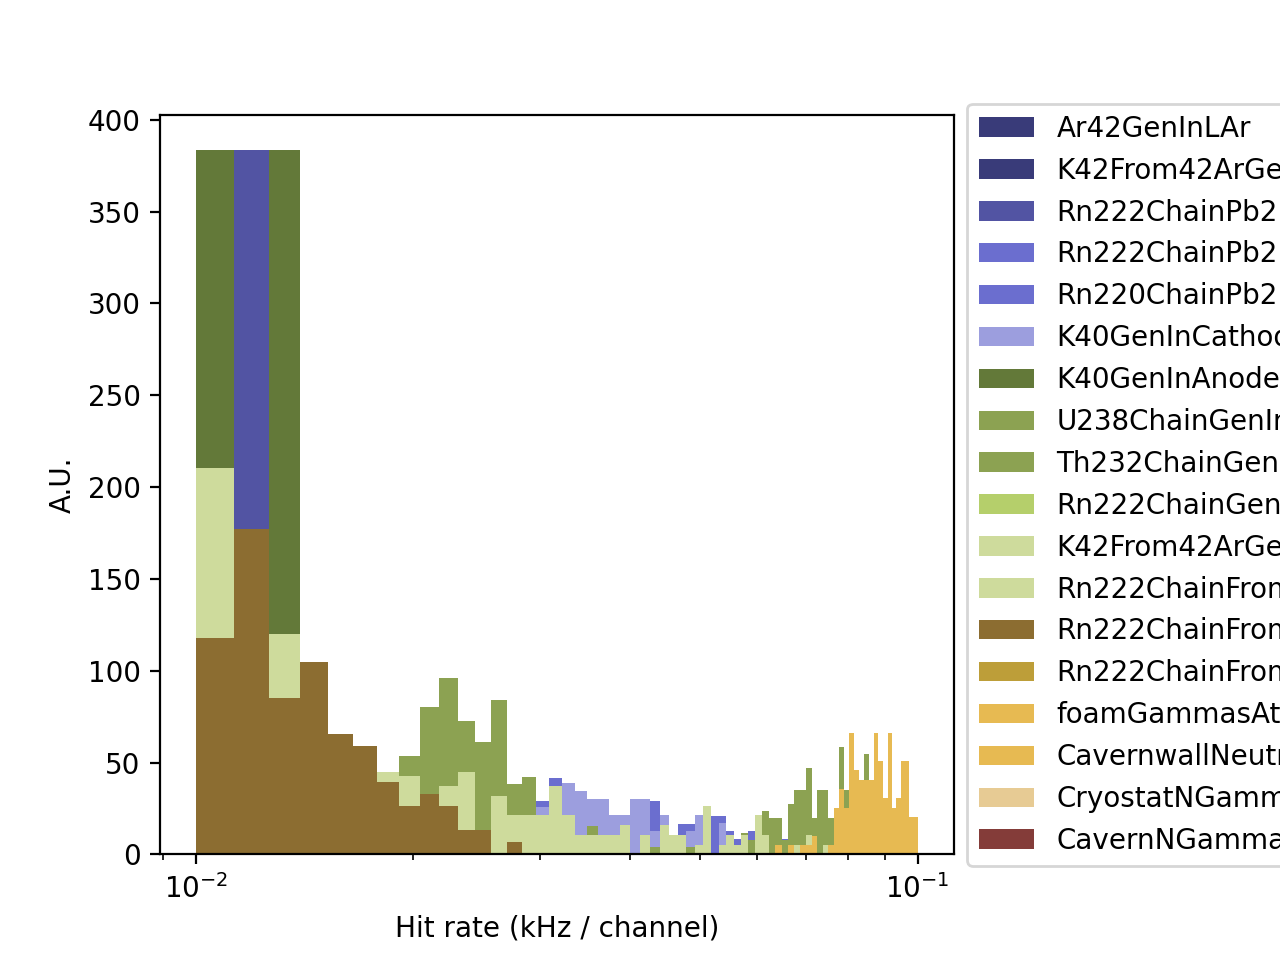

<IPython.core.display.Javascript object>


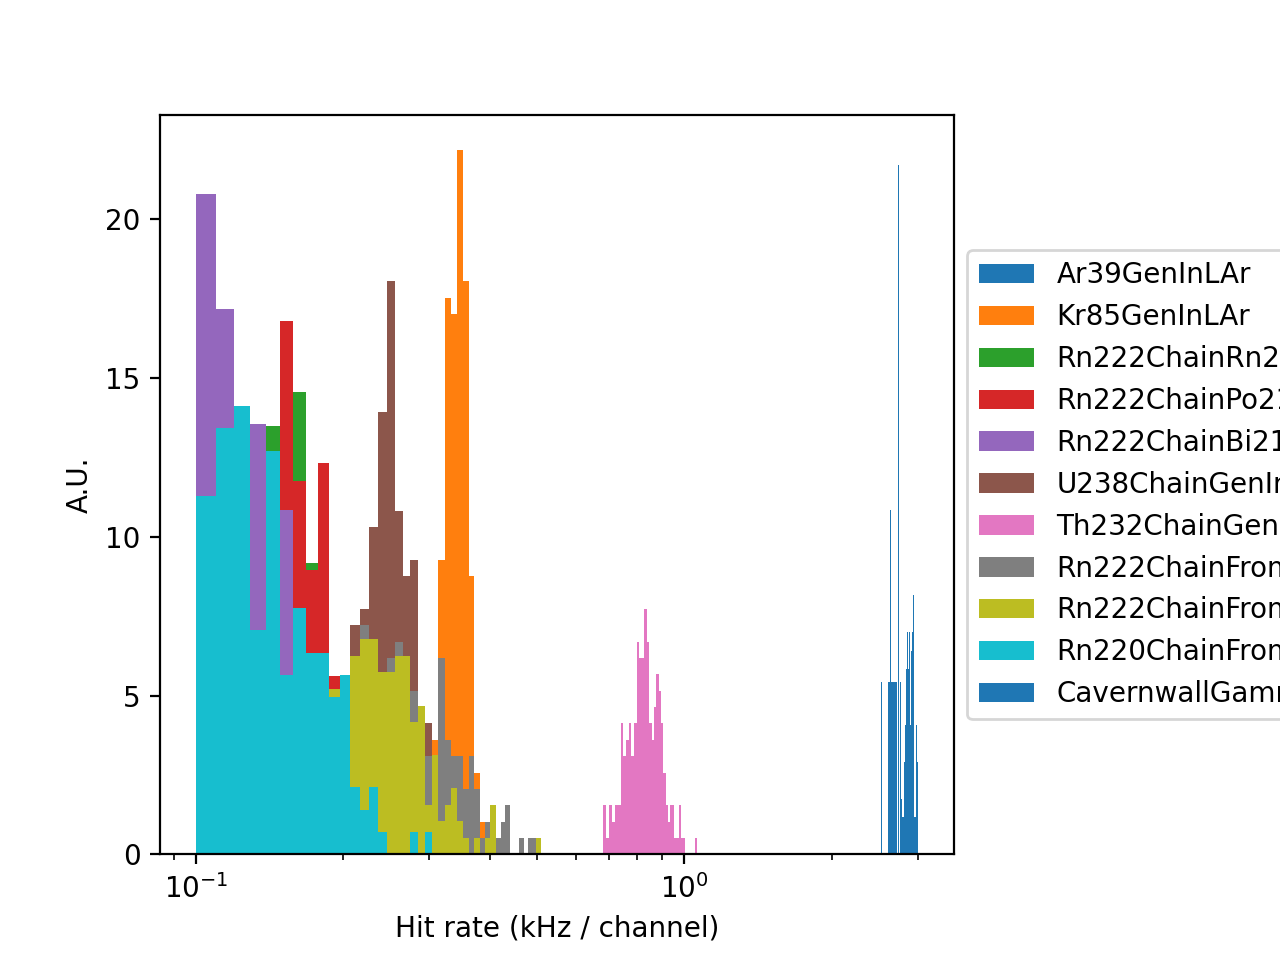

0 Ar39GenInLAr
0.7236048948564933 Hit rate (Hz / channel / cm^2)
2.6049776214833757 Hit rate (kHz / channel)
Min: 0.0 Max: 557.6470588235294
0 Total hit rate (kHz / cm^2)
2667.4970843989768 Total hit rate (kHz)


1 Kr85GenInLAr
0.094900007104291 Hit rate (Hz / channel / cm^2)
0.3416400255754476 Hit rate (kHz / channel)
Min: 54.23529411764706 Max: 72.70588235294117
0 Total hit rate (kHz / cm^2)
349.83938618925833 Total hit rate (kHz)


2 Ar42GenInLAr
9.324381926683717e-05 Hit rate (Hz / channel / cm^2)
0.0003356777493606138 Hit rate (kHz / channel)
Min: 0.0 Max: 0.9411764705882353
0 Total hit rate (kHz / cm^2)
0.34373401534526854 Total hit rate (kHz)


3 K42From42ArGenInLAr
0.0001323174197215118 Hit rate (Hz / channel / cm^2)
0.00047634271099744244 Hit rate (kHz / channel)
Min: 0.0 Max: 1.6470588235294117
0 Total hit rate (kHz / cm^2)
0.48777493606138106 Total hit rate (kHz)


4 Rn222ChainRn222GenInLAr
0.04251385336743393 Hit rate (Hz / channel / cm^2)
0.15304987212276214 Hit rate (kHz 

In [19]:
%matplotlib notebook

plot="BOTH"
vd_plot = "both" # "both", "cathode", "wall"

fig = plt.figure(1)
ax = fig.add_subplot(111)

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)

NUM_COLORS = len(bg_types)
cm = plt.get_cmap('tab20b')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])

ax.set_xlabel("Hit rate (kHz / channel)")
ax.set_xscale('log')
ax.set_ylabel("A.U.")
ax2.set_xlabel("Hit rate (kHz / channel)")
ax2.set_xscale('log')
ax2.set_ylabel("A.U.")
#ax.set_xlim(left=0.5, right=1000)


for i, type in enumerate(bg_types):
    print(i, type)
    
    total_len = 0
    lens = []
    total_len_ar = 0
    lens_ar = []
    
    for hit_list in bg_hit_list_per_event_per_type[i]:
        if detector == "HD" or (detector == "VD" and vd_plot == "both"):
            total_len += len(hit_list)
            lens.append(len(hit_list))
        elif detector == "VD" and vd_plot == "cathode":
            cathode_hits = [hit for hit in hit_list if hit[4] < 0]
            total_len += len(cathode_hits)
            lens.append(len(cathode_hits))
            num_channels = cathode_num_channels
        elif detector == "VD" and vd_plot == "wall":
            wall_hits = [hit for hit in hit_list if hit[4] > 0]
            total_len += len(wall_hits)
            lens.append(len(wall_hits))
            num_channels = wall_num_channels
    
    average_len = total_len / len(bg_hit_list_per_event_per_type[i])
    rate = average_len / bg_sample_length * 1/num_channels
    rate_per_area = rate / size_arapucas * 1000 # Hz / cm^2
    
    if rate < 0.1:
        ax.hist(np.array(lens) / bg_sample_length / num_channels, bins=np.linspace(0.01, 0.1, 70), label=type, density=True)
    if rate >= 0.1 and (plot=="BOTH" or plot=="xe"):
        ax2.hist(np.array(lens) / bg_sample_length / num_channels, bins=np.linspace(0.1, 3, 300), label=type, density=True)

    print(rate_per_area, "Hit rate (Hz / channel / cm^2)") #
    print(rate, "Hit rate (kHz / channel)") #
    print("Min:", np.min(lens)/bg_sample_length, "Max:", np.max(lens)/bg_sample_length)

    # Total rates:
    if detector == "VD":
        if vd_plot == "both":
            total_rate_mult = (352 * 2 + 320) / 184 * num_channels
            total_rate = rate * total_rate_mult
            total_rate_per_area = 0
        elif vd_plot == "cathode":
            total_rate = rate * cathode_rate_mult
            total_rate_per_area = rate_per_area * cathode_rate_mult
        elif vd_plot == "wall":
            total_rate = rate * wall_rate_mult
            total_rate_per_area = rate_per_area * wall_rate_mult
    elif detector == "HD":
        total_rate = rate * total_rate_mult * num_channels
        total_rate_per_area = rate_per_area * total_rate_mult 

    print(total_rate_per_area, "Total hit rate (kHz / cm^2)") #
    print(total_rate, "Total hit rate (kHz)") #
    print("\n")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Now also for the grouped BG types

<IPython.core.display.Javascript object>


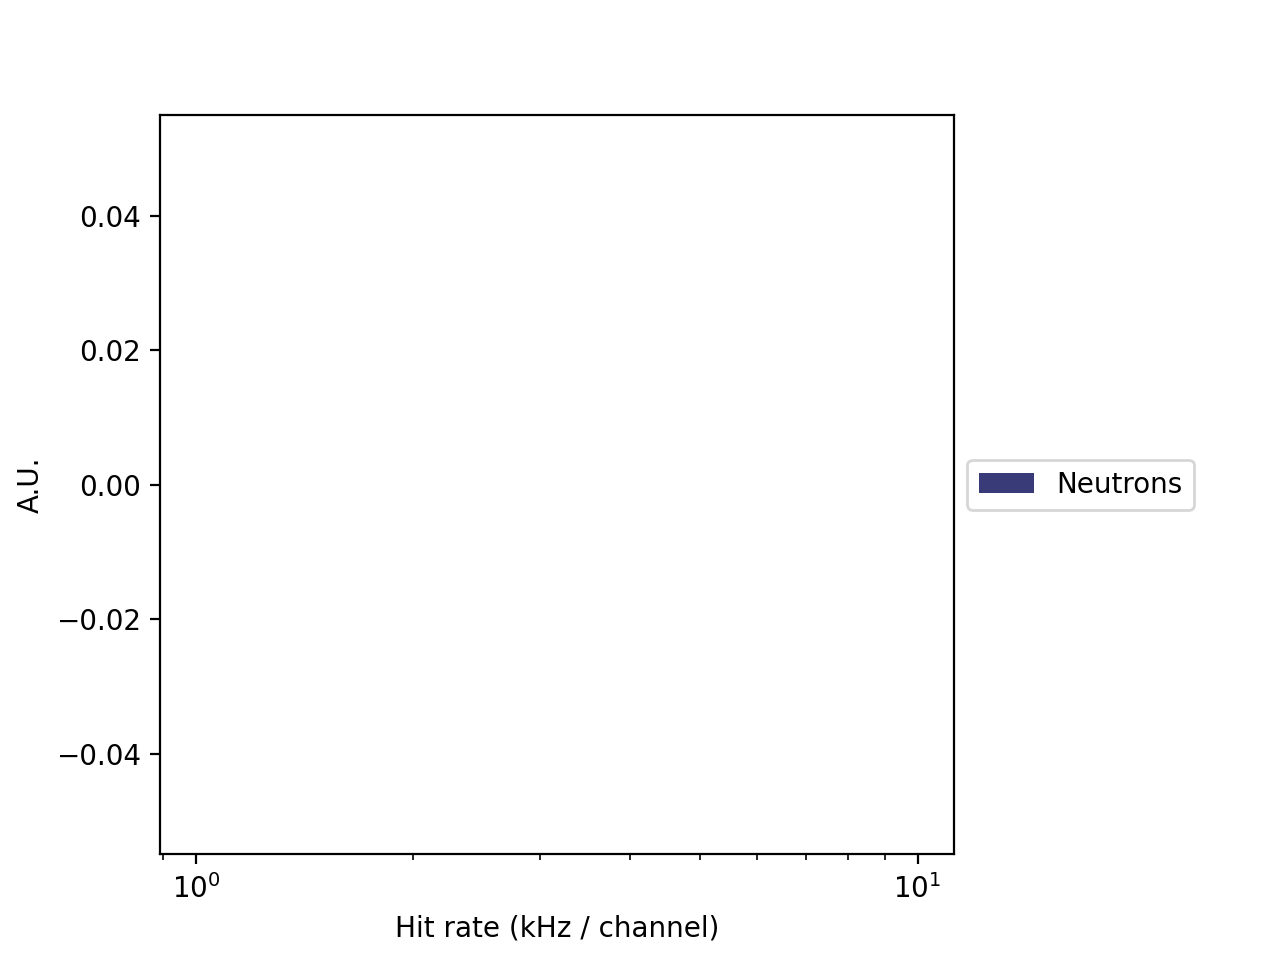

<IPython.core.display.Javascript object>


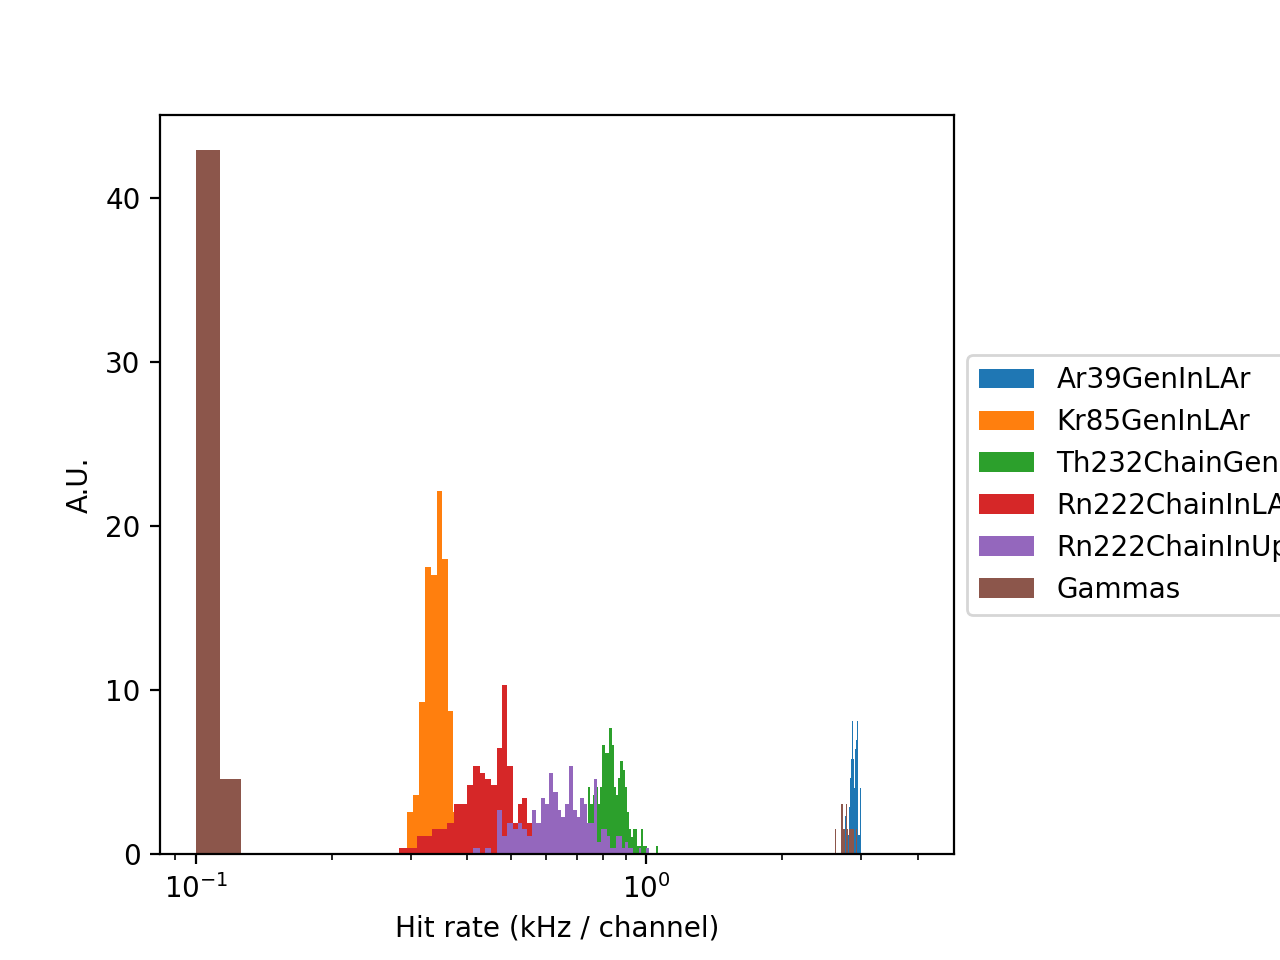

0 Ar39GenInLAr
0.7236048948564933 Hit rate (Hz / channel / cm^2)
2.6049776214833757 Hit rate (kHz / channel)
Min: 0.0 Max: 557.6470588235294
0 Total hit rate (kHz / cm^2)
2667.4970843989768 Total hit rate (kHz)


1 Kr85GenInLAr
0.094900007104291 Hit rate (Hz / channel / cm^2)
0.3416400255754476 Hit rate (kHz / channel)
Min: 54.23529411764706 Max: 72.70588235294117
0 Total hit rate (kHz / cm^2)
349.83938618925833 Total hit rate (kHz)


12 Th232ChainGenInCathode
0.23119849389030975 Hit rate (Hz / channel / cm^2)
0.8323145780051151 Hit rate (kHz / channel)
Min: 125.52941176470588 Max: 194.94117647058823
0 Total hit rate (kHz / cm^2)
852.2901278772379 Total hit rate (kHz)


0 Rn222ChainInLAr
0.12779287439613524 Hit rate (Hz / channel / cm^2)
0.4600543478260869 Hit rate (kHz / channel)
Min: 53.64705882352941 Max: 120.82352941176471
0 Total hit rate (kHz / cm^2)
471.095652173913 Total hit rate (kHz)


1 Rn222ChainInUpperMesh
0.18480658567774935 Hit rate (Hz / channel / cm^2)
0.66530370843989

In [20]:
%matplotlib notebook

plot="BOTH"
vd_plot = "both" # "both", "cathode", "wall"

fig = plt.figure(3)
ax = fig.add_subplot(111)

fig2 = plt.figure(4)
ax2 = fig2.add_subplot(111)

NUM_COLORS = len(grouped_bg_types) + len(ungrouped_bg_types)
cm = plt.get_cmap('tab20b')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])

ax.set_xlabel("Hit rate (kHz / channel)")
ax.set_xscale('log')
ax.set_ylabel("A.U.")
ax2.set_xlabel("Hit rate (kHz / channel)")
ax2.set_xscale('log')
ax2.set_ylabel("A.U.")
#ax.set_xlim(left=0.5, right=1000)

for i, type in enumerate(bg_types):
    if type not in ["Ar39GenInLAr", "Kr85GenInLAr", "Th232ChainGenInCathode"]:
        continue
    print(i, type)
    
    total_len = 0
    lens = []
    total_len_ar = 0
    lens_ar = []
    
    for hit_list in bg_hit_list_per_event_per_type[i]:
        if detector == "HD" or (detector == "VD" and vd_plot == "both"):
            total_len += len(hit_list)
            lens.append(len(hit_list))
        elif detector == "VD" and vd_plot == "cathode":
            cathode_hits = [hit for hit in hit_list if hit[4] < 0]
            total_len += len(cathode_hits)
            lens.append(len(cathode_hits))
            num_channels = cathode_num_channels
        elif detector == "VD" and vd_plot == "wall":
            wall_hits = [hit for hit in hit_list if hit[4] > 0]
            total_len += len(wall_hits)
            lens.append(len(wall_hits))
            num_channels = wall_num_channels
    
    average_len = total_len / len(bg_hit_list_per_event_per_type[i])
    rate = average_len / bg_sample_length * 1/num_channels
    rate_per_area = rate / size_arapucas * 1000 # Hz / cm^2
    
    if rate < 0.1:
        ax.hist(np.array(lens) / bg_sample_length / num_channels, bins=np.linspace(0.01, 0.1, 70), label=type, density=True)
    if rate >= 0.1 and (plot=="BOTH" or plot=="xe"):
        ax2.hist(np.array(lens) / bg_sample_length / num_channels, bins=np.linspace(0.1, 3, 300), label=type, density=True)
    

    print(rate_per_area, "Hit rate (Hz / channel / cm^2)") #
    print(rate, "Hit rate (kHz / channel)") #
    print("Min:", np.min(lens)/bg_sample_length, "Max:", np.max(lens)/bg_sample_length)

    # Total rates:
    if detector == "VD":
        if vd_plot == "both":
            total_rate_mult = (352 * 2 + 320) / 184 * num_channels
            total_rate = rate * total_rate_mult
            total_rate_per_area = 0
        elif vd_plot == "cathode":
            total_rate = rate * cathode_rate_mult
            total_rate_per_area = rate_per_area * cathode_rate_mult
        elif vd_plot == "wall":
            total_rate = rate * wall_rate_mult
            total_rate_per_area = rate_per_area * wall_rate_mult
    elif detector == "HD":
        total_rate = rate * total_rate_mult * num_channels
        total_rate_per_area = rate_per_area * total_rate_mult 

    print(total_rate_per_area, "Total hit rate (kHz / cm^2)") #
    print(total_rate, "Total hit rate (kHz)") #
    print("\n")


i = 0
for type in grouped_bg_types:
    print(i, type)
    
    total_len = 0
    lens = []
    total_len_ar = 0
    lens_ar = []
    
    for hit_list in bg_hit_list_per_event_per_grouped_type[type]:
        if detector == "HD" or (detector == "VD" and vd_plot == "both"):
            total_len += len(hit_list)
            lens.append(len(hit_list))
        elif detector == "VD" and vd_plot == "cathode":
            cathode_hits = [hit for hit in hit_list if hit[4] < 0]
            total_len += len(cathode_hits)
            lens.append(len(cathode_hits))
            num_channels = cathode_num_channels
        elif detector == "VD" and vd_plot == "wall":
            wall_hits = [hit for hit in hit_list if hit[4] > 0]
            total_len += len(wall_hits)
            lens.append(len(wall_hits))
            num_channels = wall_num_channels
    
    average_len = total_len / len(bg_hit_list_per_event_per_grouped_type[type])
    rate = average_len / bg_sample_length * 1/num_channels
    rate_per_area = rate / size_arapucas * 1000 # Hz / cm^2
    
    if rate < 0.1:
        ax.hist(np.array(lens) / bg_sample_length / num_channels, bins=np.linspace(0.01, 0.1, 70), label=type, density=True)
    if rate >= 0.1 and (plot=="BOTH" or plot=="xe"):
        ax2.hist(np.array(lens) / bg_sample_length / num_channels, bins=np.linspace(0.1, 4, 300), label=type, density=True)
    

    print(rate_per_area, "Hit rate (Hz / channel / cm^2)") #
    print(rate, "Hit rate (kHz / channel)") #
    print("Min:", np.min(lens)/bg_sample_length, "Max:", np.max(lens)/bg_sample_length)

    # Total rates:
    if detector == "VD":
        if vd_plot == "both":
            total_rate_mult = (352 * 2 + 320) / 184 * num_channels
            total_rate = rate * total_rate_mult
            total_rate_per_area = 0
        elif vd_plot == "cathode":
            total_rate = rate * cathode_rate_mult
            total_rate_per_area = rate_per_area * cathode_rate_mult
        elif vd_plot == "wall":
            total_rate = rate * wall_rate_mult
            total_rate_per_area = rate_per_area * wall_rate_mult
    elif detector == "HD":
        total_rate = rate * total_rate_mult * num_channels
        total_rate_per_area = rate_per_area * total_rate_mult 

    print(total_rate_per_area, "Total hit rate (kHz / cm^2)") #
    print(total_rate, "Total hit rate (kHz)") #
    print("\n")
    i += 1

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Distribution of PEs per hit

In [29]:
%matplotlib notebook
# What about the distribution/average PEs for each of these BG types?
for i, type in enumerate(bg_types):
    if type not in ["Ar39GenInLAr", "Kr85GenInLAr", "Rn222ChainInLAr", "NeutronGenInRock", "GammasGenInRock"]:
        continue
    print(i, type)
    
    avg_pes_list = []
    pes_list = []
    total_pes = []
    pes = []
    lens = 0
    
    for hit_list in bg_hit_list_per_event_per_type[i]:
        if len(hit_list) == 0:
            continue
        total_pes.extend(hit_list[:, -1])
        pes_list.append(hit_list[:, -1])
        avg_pes_list.append(np.mean(hit_list[:, -1]))
        lens += len(hit_list)
    
    average_pes = np.sum(total_pes) / lens
    rate = average_pes / bg_sample_length

    plt.hist(np.array(total_pes), bins=np.logspace(0, 2, 100), label=type, density=True, histtype='step', linewidth=2, linestyle='-')
    mean = np.mean(np.array(total_pes))
    mode = stats.mode(np.array(total_pes))[0][0]
    print("Type", mean, mode)
    
    #print(rate, "(PEs per ms)")
    # print(average_pes, "average PEs per hit")
    # print("Min:", np.min(total_pes), "Max:", np.max(total_pes))
    # print("--------")

# Also include the SN events (below 30 MeV)
avg_pes_list = []
pes_list = []
total_pes = []
pes = []
lens = 0
for i, hit_list in enumerate(sn_hit_list_per_event):
    # If energy is avove 30 MeV, skip
    if sn_info_per_event[i, 0] > 30:
        continue
    if len(hit_list) == 0:
        continue
    total_pes.extend(hit_list[:, -1])
    pes_list.append(hit_list[:, -1])
    avg_pes_list.append(np.mean(hit_list[:, -1]))
    lens += len(hit_list)

average_pes = np.sum(total_pes) / lens
rate = average_pes / bg_sample_length
plt.hist(np.array(total_pes), bins=np.logspace(0, 2, 100), label="SN events", density=True, histtype='step', linewidth=3, color="black")
mean = np.mean(np.array(total_pes))
mode = stats.mode(np.array(total_pes))[0][0]
print("SN", mean, mode)


# get the unique values and their frequency count
unique_values, occur_count = np.unique(np.array(total_pes), return_counts=True)

print(unique_values[1730:1740], occur_count[1730:1740])
print(np.diff(unique_values))

plt.xlabel("PEs")
#plt.xscale('log')
plt.yscale('log')
plt.legend()


0 Ar39GenInLAr


/tmp/ipykernel_20597/1148698060.py:27: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(np.array(total_pes))[0][0]


Type 10.878499871884634 5.022307872772217
1 Kr85GenInLAr
Type 11.08519881288454 5.045384407043457
SN 17.993829357635164 6.091538429260254
[7.39153862 7.39410257 7.39666653 7.39923096 7.40179491 7.40435886
 7.40692329 7.40948725 7.4120512  7.41461515] [366 148 143 340 114 152 338 134 142 344]
[9.23078060e-02 2.30767727e-02 1.53846741e-02 ... 5.07929688e+01
 1.04250781e+03 1.10312500e+02]


/tmp/ipykernel_20597/1148698060.py:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(np.array(total_pes))[0][0]


## Draw the cube

<IPython.core.display.Javascript object>


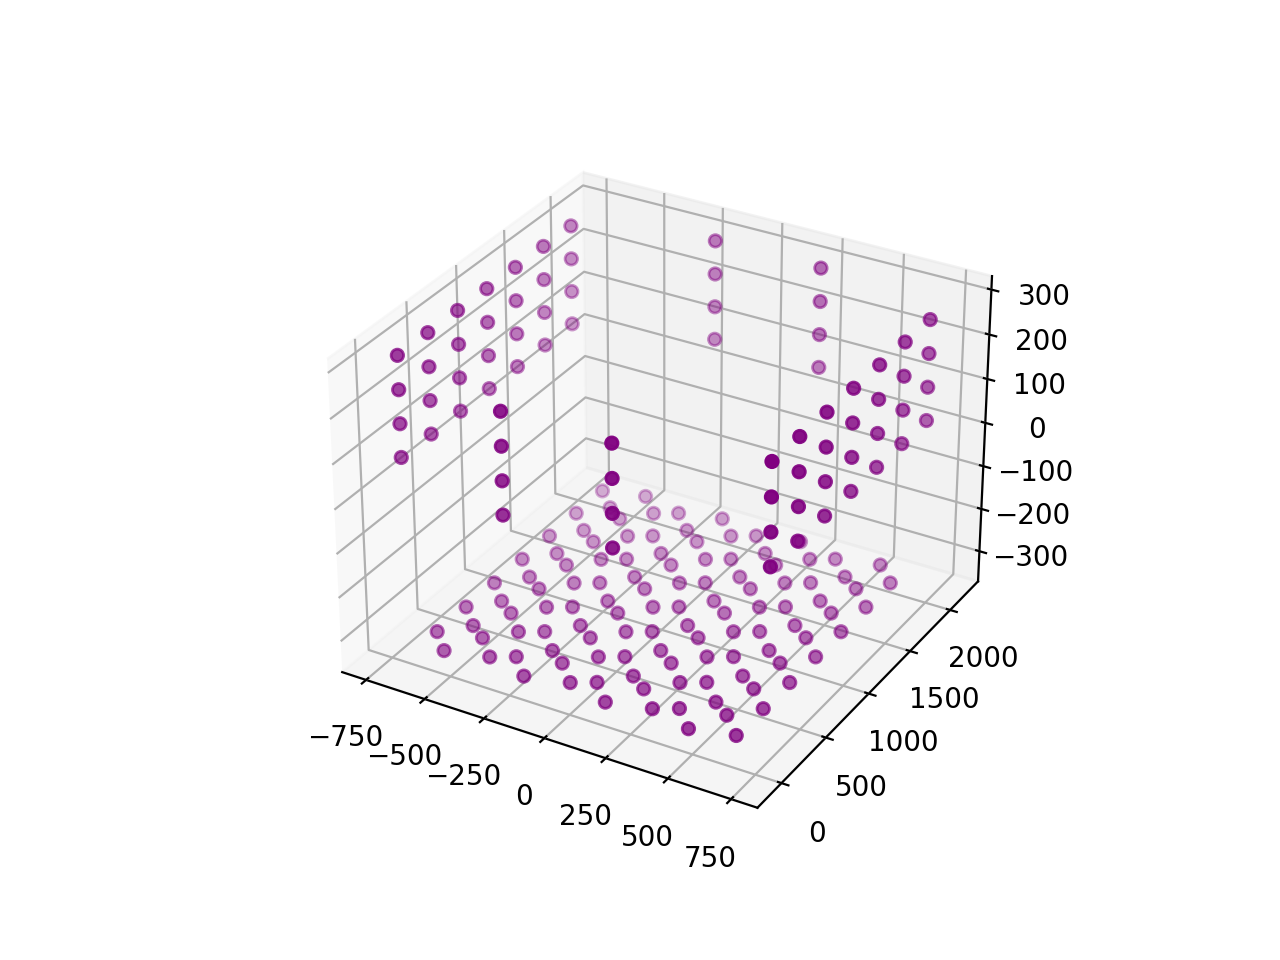

In [14]:
%matplotlib notebook
# Plot the opdet positions in 3D (184 OpChannels)
x, y, z = X_COORDS, Y_COORDS, Z_COORDS

# If VD, we have a proper 3D plot:
if detector == "VD":
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(y, z, x, c='purple', marker='o')

# If HD, we have a 2D plot:
elif detector == "HD":
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(z, y, c='purple', marker='o')

<IPython.core.display.Javascript object>


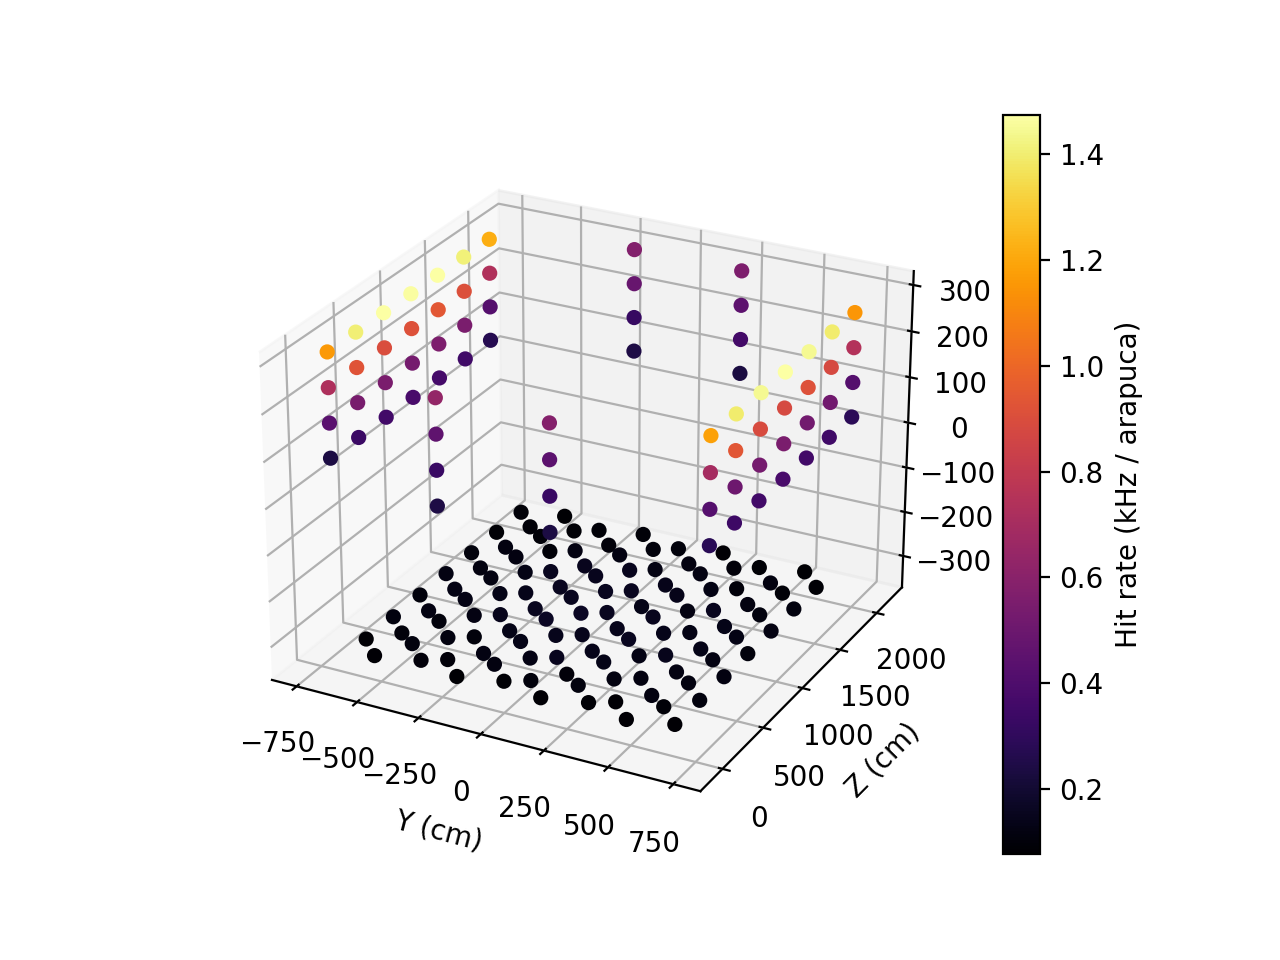

15.411764705882353


In [26]:
# Draw it for a specific bg type
%matplotlib notebook
arapuca_counts = np.zeros(num_channels)

used_grouped = True

if not used_grouped:
    # 12 Th232ChainGenInCathode
    tp = 12
    for hit_list in bg_hit_list_per_event_per_type[tp]:
        for hit in hit_list:
            arapuca_counts[int(hit[2])] += 1
    event_num = len(bg_hit_list_per_event_per_type[tp])
else:
    # Or if we want the grouped types
    tp = "Gammas"
    for hit_list in bg_hit_list_per_event_per_grouped_type[tp]:
        for hit in hit_list:
            arapuca_counts[int(hit[2])] += 1
    event_num = len(bg_hit_list_per_event_per_grouped_type[tp])
        
x, y, z = X_COORDS, Y_COORDS, Z_COORDS



if detector == "VD":

    # Frequency (kHz) per arapuca
    fig = plt.figure(10)

    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(y, z, x, c=arapuca_counts/bg_sample_length/event_num, cmap='inferno', marker='o', alpha=1)
    plt.colorbar(scatter, label="Hit rate (kHz / arapuca)")
    print(min(arapuca_counts/bg_sample_length))
    ax.set_xlabel("Y (cm)")
    ax.set_ylabel("Z (cm)")
    ax.set_zlabel("X (cm)")

    # Frequency (kHz) per cm^2
    # fig = plt.figure(20)
    # ax = fig.add_subplot(111, projection='3d')
    # scatter = ax.scatter(y, z, x, c=arapuca_counts/bg_sample_length/size_arapucas, cmap='inferno', marker='o', alpha=1)
    # plt.colorbar(scatter, label="Hits/ms per cm^2")

elif detector == "HD":
    fig = plt.figure(10)
    ax = fig.add_subplot(111)
    scatter = ax.scatter(z, y, c=arapuca_counts/bg_sample_length/event_num, cmap='inferno', marker='o')
    plt.colorbar(scatter, label="Hit rate (kHz / arapuca)")

    plt.xlabel("Z (cm)")
    plt.ylabel("Y (cm)")